<a href="https://colab.research.google.com/github/tmnmdcm/Aiaiai/blob/main/copy_of_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
shutil.unpack_archive('/content/drive/MyDrive/NordTank586x371.zip', '/content/dataset')

In [4]:
# Define paths
drive_path = "/content/"
train_image_path = drive_path + "dataset/NordTank586x371/Train/images"
test_image_path = drive_path + "dataset/NordTank586x371/Test/images"
train_label_path = drive_path + "dataset/NordTank586x371/Train/labels"
test_label_path = drive_path + "dataset/NordTank586x371/Test/labels"

In [5]:
image_path = drive_path + "dataset/NordTank586x371/Train/images/DJI_0004_03_07.png"
image = cv2.imread(image_path)

image_shape = image.shape

# image_height, image_width, num_channels = image_shape

image_height, image_width, num_channels = (128, 128, 3)

In [6]:
class_names = ["Damage/Dirt", "No Damage/Dirt"]

train_limit = 800
test_limit = 200

# if not train_limit:
n_train = min(len(os.listdir(train_image_path)), train_limit)
n_test = min(len(os.listdir(test_image_path)), test_limit)


In [7]:
def _generate_batch_train_images(start_index, end_index):
    n = end_index - start_index + 1
    train_images = np.zeros(n, dtype=(np.float32, (image_height, image_width, num_channels)))
    train_labels = np.zeros(n)


    # Add train images and labels into array
    for idx, image_path in enumerate(os.listdir(train_image_path)[:train_limit][start_index:end_index]):
        image = cv2.imread(os.path.join(train_image_path, image_path))
        image = cv2.resize(image, (image_height, image_width))
        image = image / 255.0  # Scale pixel values to [0, 1]
        train_images[idx] = image

        label_path = image_path[:-3] + "txt"

        with open(os.path.join(train_label_path, label_path), 'r') as f:
            train_labels[idx] = (f.read().strip() == class_names[1])

    return train_images, train_labels

def _generate_batch_test_images(start_index, end_index):
    n = end_index - start_index + 1
    test_images = np.zeros(n, dtype=(np.float32, (image_height, image_width, num_channels)))
    test_labels = np.zeros(n)


    # Add train images and labels into array
    for idx, image_path in enumerate(os.listdir(test_image_path)[:test_limit][start_index:end_index]):
        image = cv2.imread(os.path.join(test_image_path, image_path))
        image = cv2.resize(image, (image_height, image_width))
        image = image / 255.0  # Scale pixel values to [0, 1]
        test_images[idx] = image

        label_path = image_path[:-3] + "txt"

        with open(os.path.join(test_label_path, label_path), 'r') as f:
            test_labels[idx] = (f.read().strip() == class_names[1])

    return test_images, test_labels

In [8]:
# Batch generator for training images


class batch_train(batch_size):
    num_samples = n_train

    indices = np.arange(num_samples)

    for start_index in range(0, num_samples, batch_size):
        end_index = min(start_index + batch_size, num_samples)
        # batch_indices = indices[start_index:end_index]

        yield _generate_batch_train_images(start_index, end_index)


def batch_test(batch_size):
    num_samples = n_test

    indices = np.arange(num_samples)

    for start_index in range(0, num_samples, batch_size):
        end_index = min(start_index + batch_size, num_samples)
        # batch_indices = indices[start_index:end_index]

        yield _generate_batch_test_images(start_index, end_index)



In [9]:
# 0 -> No damage
# 1 -> Dirt/Damage

In [10]:
# Define the model
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Use a single unit with sigmoid activation for binary classification

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'Precision', 'Recall'])

In [11]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Stops training when 95% accuracy is reached
    '''
    # Get the current accuracy and check if it is above 95%
    if(logs.get('accuracy') > 0.95):

      # Stop training if condition is met
      print("\nThreshold reached. Stopping training...")
      self.model.stop_training = True

# Let's instantiate our ES class
early_stopping = EarlyStopping()

In [17]:
batch_size = 32

train_batch_generator = batch_train(batch_size)
test_batch_generator = batch_test(batch_size)

for i in range(n_train // batch_size):
  n = next(train_batch_generator)
  print(n[0].shape)




(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)
(33, 128, 128, 3)


StopIteration: ignored

In [19]:
# Train the model

batch_size = 32

train_batch_generator = batch_train(batch_size)
test_batch_generator = batch_test(batch_size)

train_dataset = tf.data.Dataset.from_generator(train_batch_generator)
test_dataset = tf.data.Dataset.from_generator(test_batch_generator)

history = model.fit(train_dataset.repeat(10), epochs=10,
                    validation_data=test_dataset.repeat(10),
                    steps_per_epoch=n_train // batch_size,
                    validation_steps=n_test // batch_size,
                    callbacks=[early_stopping])

TypeError: ignored

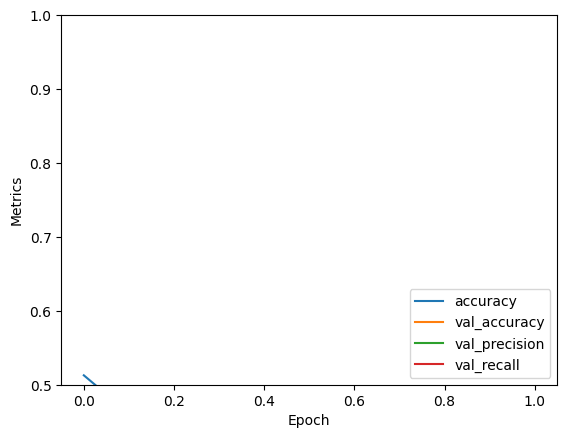

In [13]:
# Plot metrics
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_precision'], label='val_precision')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [14]:
# Evaluate the model
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_images, test_labels, verbose=2)
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print("test accuracy:", test_acc)
print("test precision:", test_precision)
print("test recall:", test_recall)
print("test F1-score:", test_f1_score)

NameError: ignored